## IMPORTING MODULES

In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models,layers
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers import add
from keras.models import Model, load_model

## CHANGING THE DIRECTORY

In [2]:
data_dir='C:/Users/DELL/OneDrive/Desktop/archive'
work_dir='C:/Users/DELL'
os.chdir(data_dir)

In [3]:
img_dir=data_dir+'/Images'
img_list=os.listdir(img_dir)

## SHOWING SOME IMAGES 

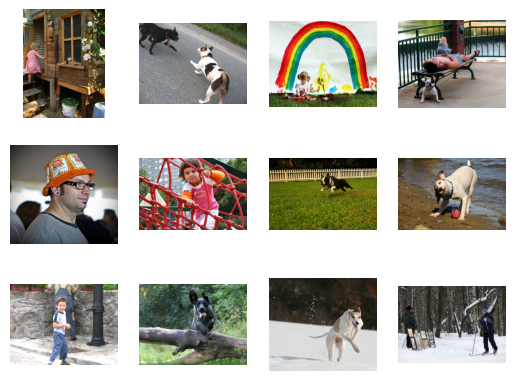

In [4]:
for i in range (12):
    plt.subplot(3,4,i+1)
    img=Image.open(os.path.join(img_dir, img_list[i]))
    plt.imshow(img)
    plt.axis("off")

## EXTRACTING THE FEATURES

In [99]:
model = VGG16()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
features={}
for img_name in tqdm(img_list):
    img=image.load_img(os.path.join(img_dir, img_name),target_size=(224,224))
    img = image.img_to_array(img) 
    img=img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature=model.predict(img,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature
    
    
    
    



100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [33:13<00:00,  4.06it/s]


## SAVING THE FEATURES

In [100]:
pickle.dump(features,open(os.path.join(data_dir,'features.pkl'),'wb'))


## LOADING THE FEATURES

In [4]:
with open(os.path.join(data_dir,'features.pkl'),'rb') as file:
    features=pickle.load(file)

In [5]:
features['1674612291_7154c5ab61']



array([[3.5897655, 1.5534395, 0.       , ..., 0.       , 0.7495728,
        1.122608 ]], dtype=float32)

In [6]:
with open(os.path.join(data_dir,'captions.txt'),'r') as file:
    next(file)
    captions_list=file.read()

## CREATING A DIC THAT CONTAINS CAPTIONS FOR EACH IMAGE IN A ARRAY


In [7]:
cap_dic={}
for line in tqdm(captions_list.split('\n')):
    token=line.split(',')
    if len(line) < 2:
        continue
    image_id,caption=token[0],token[1:]
    image_id=image_id.split('.')[0]
    caption=" ".join(caption)
    if image_id not in cap_dic:
        cap_dic[image_id]=[]
    cap_dic[image_id].append(caption)
    

100%|████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 709731.61it/s]


## TEXT PRE-PROCESSING

In [8]:
len(cap_dic)

8091

In [9]:
def cleaning(cap_dic):
    for key,captions in cap_dic.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq '+ " ".join([word for word in caption.split() if len(word)>1])  + ' endseq'
            captions[i]=caption
        
    

In [10]:
cap_dic
len(cap_dic)


8091

In [11]:
cleaning(cap_dic)

## TRAIN AND TEST SPLIT[NUMBERS]

In [12]:
total_ids=list(cap_dic.keys())
train_no=int(len(total_ids)*0.9)
train=total_ids[:train_no]
test=total_ids[train_no:]


## Tokenization

In [13]:
cap_list= []
for key in cap_dic:
    for caption in cap_dic[key]:
        cap_list.append(caption)

In [14]:
len(cap_list)
cap_list[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
len(features['1000268201_693b08cb0e'])

1

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cap_list)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
max_length = max(len(caption.split()) for caption in cap_list)

In [18]:
vocab_size

8485

In [19]:
max_length

35

In [20]:
def data_generator(keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in keys:
            n+=1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)   
                yield [X1,X2],y
                X1,X2,y=list(),list(),list()
                n=0


## MODEL

In [22]:
from keras.utils import plot_model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
    

In [23]:
epochs=25
batch_size=64
steps=len(train)//batch_size

for i in range(epochs):
    data_gen=data_generator(train,cap_dic,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(data_gen,epochs=1,steps_per_epoch=steps,verbose=1)


113/113 [==============================] - 396s 4s/step - loss: 2.2314


In [24]:
model.save('caption.keras')

In [25]:
model.save_weights('caption_weights.keras')

In [21]:
loaded_model=load_model('caption.keras')

In [22]:
def index_to_word(value,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==value:
            return word
    return None

In [23]:
def gen_caption(model,image,tokenizer,max_length):
    inp_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([inp_text])[0]
        sequence=pad_sequences([sequence],max_length)
        output=model.predict([image,sequence],verbose=0)
        output=np.argmax(output)
        word=index_to_word(output,tokenizer)
        if word is None:
            break
        inp_text+=" " + word
        if word=='endseq':
            break
    return inp_text

    

    

In [24]:
actual,predicted=list(),list()
for key in tqdm(test):
    captions=cap_dic[key]
    y_pred=gen_caption(loaded_model,features[key],tokenizer,max_length)
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [10:47<00:00,  1.25it/s]


In [26]:
from nltk.translate.bleu_score import corpus_bleu
print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0,)))

BLEU-1: 0.544571


In [27]:
def img_cap(image_name):
    image_id=image_name.split('.')[0]
    img_path=os.path.join(img_dir,image_name)
    image=Image.open(img_path)
    captions=cap_dic[image_id]
    print('***************ACTUAL*****************')
    for caption in captions:
        print(caption)
    pred=gen_caption(loaded_model,features[image_id],tokenizer,max_length)
    print('****************PREDICTED***************')
    print(pred)
    plt.imshow(image)

***************ACTUAL*****************
startseq black and brown dog is running out of the surf endseq
startseq wet dog runs through the surf at beach endseq
startseq wet german shepherd dog is running out of the ocean with ball in its mouth endseq
startseq german shepherd running in ocean surf endseq
startseq the german shepherd is walking in the body of water endseq
****************PREDICTED***************
startseq dog is walking through the ocean endseq


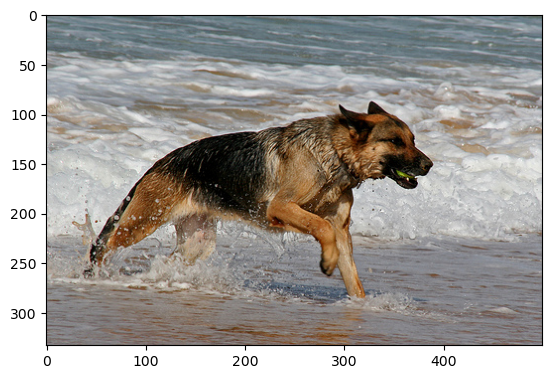

In [29]:
img_cap("225909073_25c3c33a29.jpg")
